In [1]:
# generic imports for making a synth ccd image
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pylab as plt
plt.rcParams['image.origin'] = 'lower' 
from photutils.aperture import EllipticalAperture
import cmath

### Blank Image

In [2]:
# file full of zeros of the desired width and height
synthetic_image = np.zeros([1000, 1000])

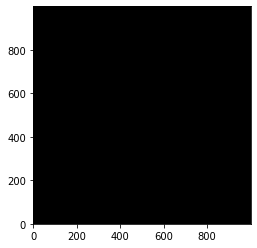

In [3]:
plt.imshow(synthetic_image, cmap='gray', origin='lower')

### Adding readnoise

In [4]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = np.random.normal(scale=amount/gain, size=shape)
    
    return noise

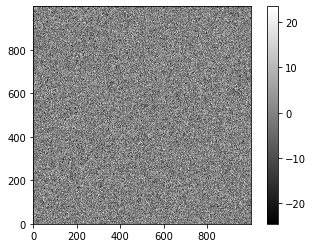

In [5]:
plt.figure()
noise_im = synthetic_image + read_noise(synthetic_image, 5)
plt.imshow(noise_im, cmap='gray', origin='lower')
plt.colorbar()

### Adding bias

In [6]:
def bias(image, value, realistic=False):
    """
    Generate simulated bias image.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some columns with somewhat higher bias value (a not uncommon thing)
    """
    # This is the whole thing: the bias is really suppose to be a constant offset!
    bias_im = np.zeros_like(image) + value
    
    # If we want a more realistic bias we need to do a little more work. 
    if realistic:
        shape = image.shape
        number_of_colums = 5
        
        # We want a random-looking variation in the bias, but unlike the readnoise the bias should 
        # *not* change from image to image, so we make sure to always generate the same "random" numbers.
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums)
        # This adds a little random-looking noise into the data.
        col_pattern = rng.randint(0, int(0.1 * value), size=shape[0])
        
        # Make the chosen columns a little brighter than the rest...
        for c in columns:
            bias_im[:, c] = value + col_pattern
            
    return bias_im
        

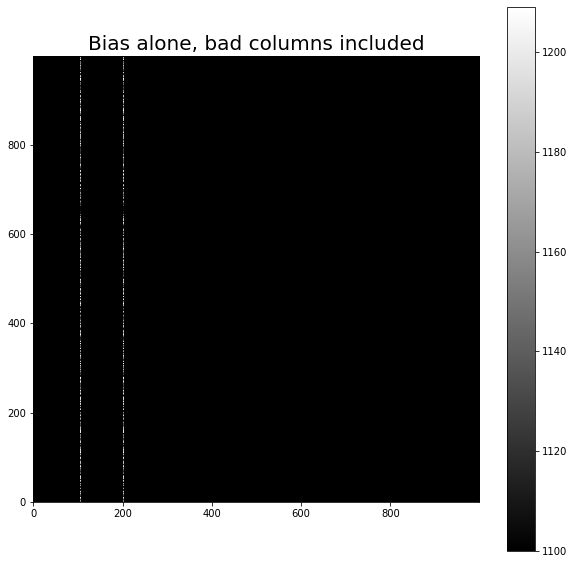

In [7]:
bias_only = bias(synthetic_image, 1100, realistic=True)
plt.figure(figsize=(10,10))
plt.imshow(bias_only, cmap='gray', origin='lower')
plt.title('Bias alone, bad columns included', fontsize='20')
plt.colorbar()

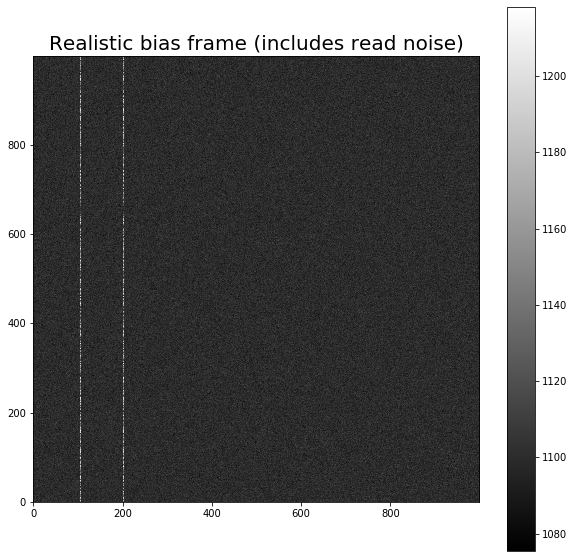

In [8]:
bias_noise_im = noise_im + bias_only
plt.figure(figsize=(10,10))
plt.imshow(bias_noise_im, cmap='gray')
plt.title('Realistic bias frame (includes read noise)', fontsize='20')
plt.colorbar()

### Dark current

In [9]:
def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simulate dark current in a CCD, optionally including hot pixels.
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    current : float
        Dark current, in electrons/pixel/second, which is the way manufacturers typically 
        report it.
    exposure_time : float
        Length of the simulated exposure, in seconds.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    strength : float, optional
        Pixel count in the cosmic rays.    
    """
    
    # dark current for every pixel; we'll modify the current for some pixels if 
    # the user wants hot pixels.
    base_current = current * exposure_time / gain
    
    # This random number generation should change on each call.
    dark_im = np.random.poisson(base_current, size=image.shape)
        
    if hot_pixels:
        # We'll set 0.01% of the pixels to be hot; that is probably too high but should 
        # ensure they are visible.
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.0001 * x_max * y_max)
        
        # Like with the bias image, we want the hot pixels to always be in the same places
        # (at least for the same image size) but also want them to appear to be randomly
        # distributed. So we set a random number seed to ensure we always get the same thing.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 10000 * current
        
        dark_im[[hot_y, hot_x]] = hot_current * exposure_time / gain
    return dark_im

C:\Users\mjfer\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


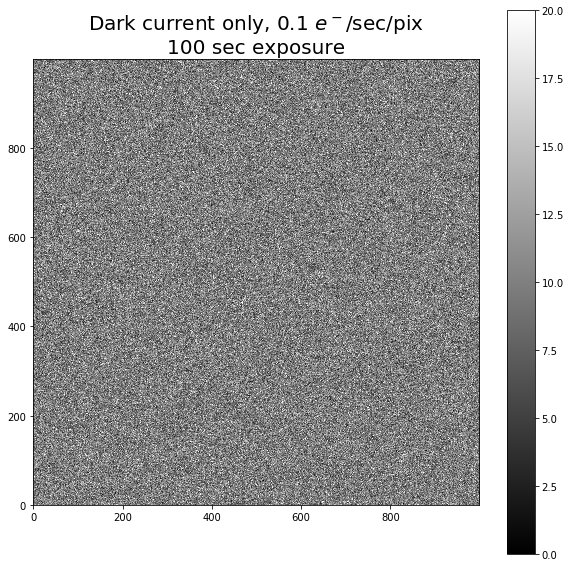

In [10]:
dark_exposure = 100
dark_cur = 0.1
dark_only = dark_current(synthetic_image, dark_cur, dark_exposure, hot_pixels=True)
plt.figure(figsize=(10,10))
plt.imshow(dark_only, cmap='gray', vmin=0, vmax=20)
title_string = 'Dark current only, {dark_cur} $e^-$/sec/pix\n{dark_exposure} sec exposure'.format(dark_cur=dark_cur, dark_exposure=dark_exposure)
plt.title(title_string, fontsize='20');
plt.colorbar()

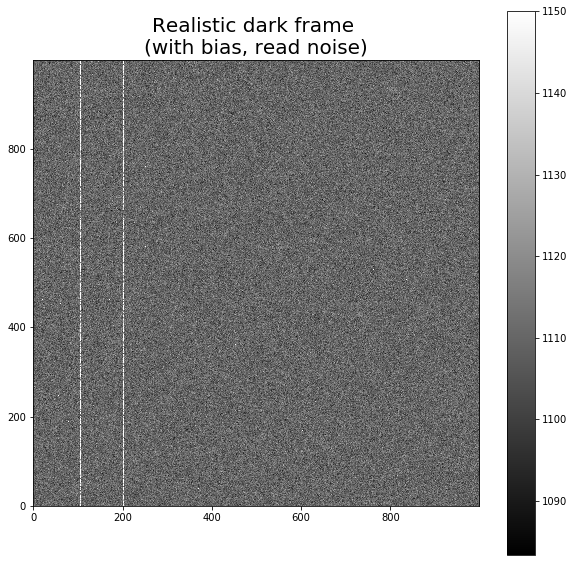

In [11]:
dark_bias_noise_im = bias_noise_im + dark_only
plt.figure(figsize=(10,10))
plt.imshow(dark_bias_noise_im, cmap='gray', vmax=1150)
plt.title('Realistic dark frame \n(with bias, read noise)', fontsize='20')
plt.colorbar()

### Sky background

In [12]:
def sky_background(image, sky_counts, gain=1):
    """
    Generate sky background, optionally including a gradient across the image (because
    some times Moons happen).
    
    Parameters
    ----------
    
    image : numpy array
        Image whose shape the cosmic array should match.
    sky_counts : float
        The target value for the number of counts (as opposed to electrons or 
        photons) from the sky.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    sky_im = np.random.poisson(sky_counts * gain, size=image.shape) / gain
    
    return sky_im

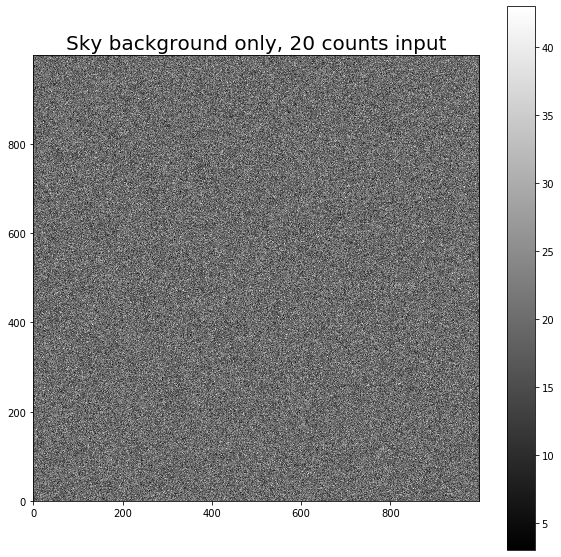

In [13]:
sky_level = 20
sky_only = sky_background(synthetic_image, sky_level)
plt.figure(figsize=(10,10))
plt.imshow(sky_only, cmap='gray')
plt.title('Sky background only, {} counts input'.format(sky_level), fontsize=20)
plt.colorbar()

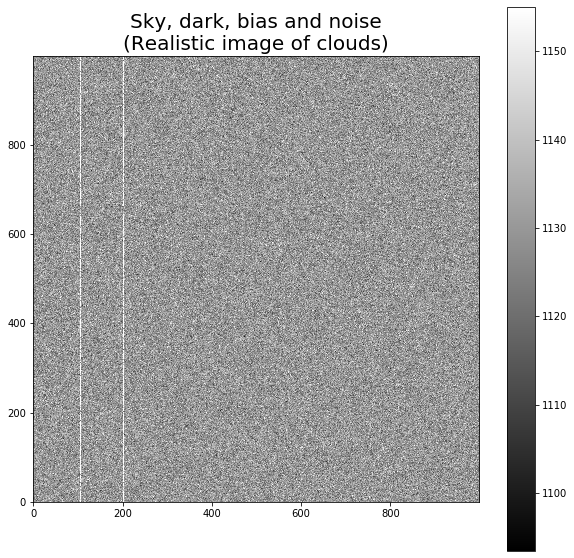

In [14]:
sky_dark_bias_noise_im = dark_bias_noise_im + sky_only
plt.figure(figsize=(10,10))
plt.imshow(sky_dark_bias_noise_im, cmap='gray', vmax=1155)
plt.title('Sky, dark, bias and noise\n(Realistic image of clouds)', fontsize=20);
plt.colorbar()

### Stars

In [15]:
def stars(image, number, max_counts=10000, gain=1):
    """
    Add some stars to the image.
    """
    from photutils.datasets import make_random_gaussians_table, make_gaussian_sources_image
    # Most of the code below is a direct copy/paste from
    # https://photutils.readthedocs.io/en/stable/_modules/photutils/datasets/make.html#make_100gaussians_image
    
    flux_range = [max_counts/100, max_counts]
    
    y_max, x_max = image.shape
    xmean_range = [0.1 * x_max, 0.9 * x_max]
    ymean_range = [0.1 * y_max, 0.9 * y_max]
    xstddev_range = [1, 4]
    ystddev_range = [1, 4]
    params = dict([('amplitude', flux_range),
                  ('x_mean', xmean_range),
                  ('y_mean', ymean_range),
                  ('x_stddev', xstddev_range),
                  ('y_stddev', ystddev_range),
                  ('theta', [0, 2*np.pi])])

    sources = make_random_gaussians_table(number, params,
                                          random_state=12345)
    
    star_im = make_gaussian_sources_image(image.shape, sources)
    
    return star_im

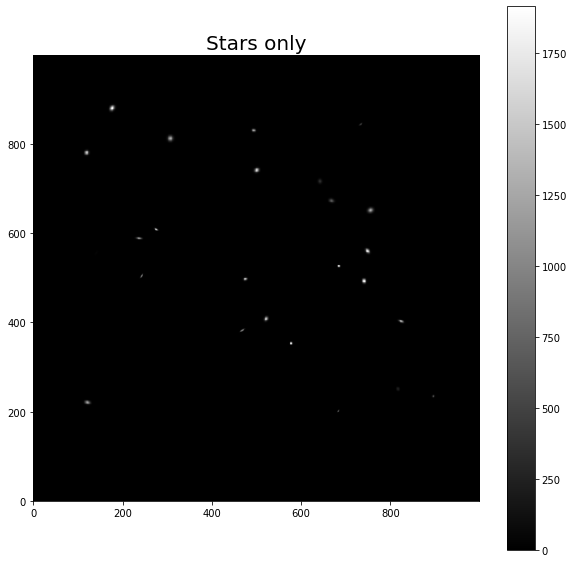

In [16]:
stars_only = stars(synthetic_image, 25, max_counts=2000)
plt.figure(figsize=(10,10))
plt.imshow(stars_only, cmap='gray')
plt.title('Stars only'.format(stars_only), fontsize=20)
plt.colorbar()

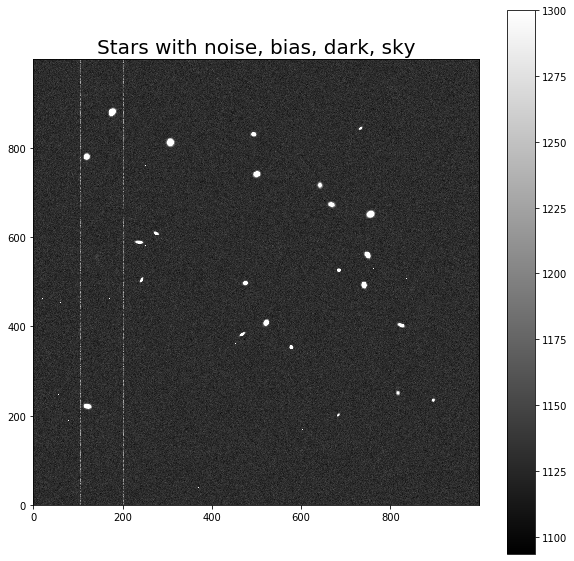

In [17]:
stars_with_background = sky_dark_bias_noise_im + stars_only
plt.figure(figsize=(10,10))
plt.imshow(stars_with_background, cmap='gray', vmax=1300)
plt.title('Stars with noise, bias, dark, sky'.format(stars_with_background), fontsize=20)
plt.colorbar()

### Testing data

In [18]:
import matplotlib.pyplot as plt
from astropy.io import fits
from turbustat.simulator import make_extended

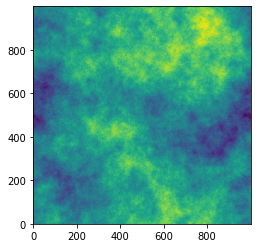

In [19]:
turbulent_synth = make_extended(1000, powerlaw=3.)
plt.imshow(turbulent_synth)

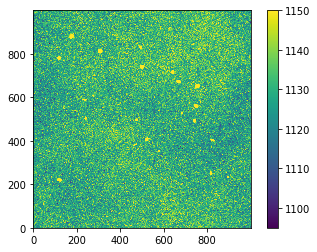

In [20]:
turbulent_im = turbulent_synth + stars_with_background
plt.imshow(turbulent_im, vmax=1150)
plt.colorbar()

#### Airy Function

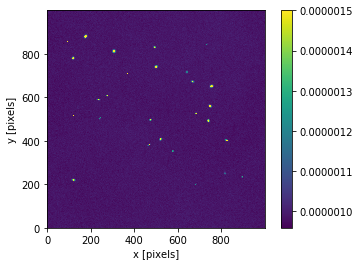

In [21]:
from astropy.convolution import AiryDisk2DKernel
fwhm = 2.35/0.75
airystars = AiryDisk2DKernel(fwhm, array=turbulent_im)
plt.imshow(airystars, interpolation='none', origin='lower', vmax=0.0000015)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

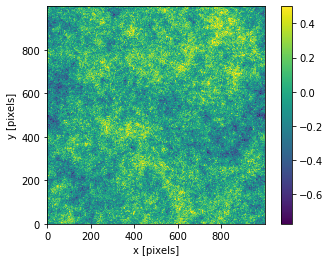

In [22]:
starstest = stars(synthetic_image, 25, max_counts=2500) + dark_bias_noise_im
turbulence = make_extended(1000, powerlaw=2)
turbulenttest = turbulence + starstest
plt.imshow(turbulence, interpolation='none', origin='lower', vmax=0.5)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

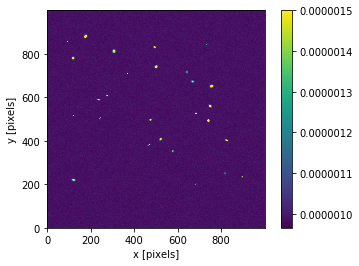

In [23]:
airystarstest = AiryDisk2DKernel(fwhm, array=starstest)
plt.imshow(airystarstest, interpolation='none', origin='lower', vmax=0.0000015)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

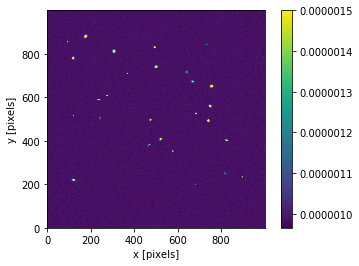

In [24]:
airyturbtest = AiryDisk2DKernel(fwhm, array=turbulenttest)
plt.imshow(airyturbtest, interpolation='none', origin='lower', vmax=0.0000015)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

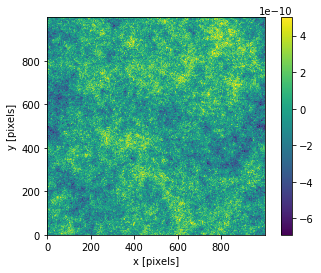

In [25]:
testtest = airyturbtest - airystarstest
plt.imshow(testtest, interpolation='none', origin='lower', vmax=0.0000000005)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

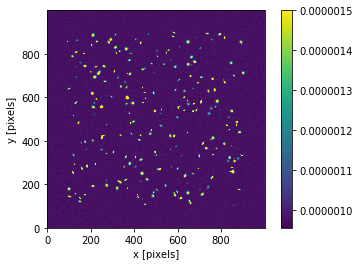

In [26]:
starstest2 = stars(synthetic_image, 250, max_counts=2500) + dark_bias_noise_im
turbulenttest2 = turbulence + starstest2
airystarstest2 = AiryDisk2DKernel(fwhm, array=starstest2)
plt.imshow(airystarstest2, interpolation='none', origin='lower', vmax=0.0000015)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

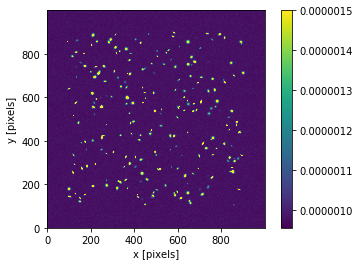

In [27]:
airyturbtest2 = AiryDisk2DKernel(fwhm, array=turbulenttest2)
plt.imshow(airyturbtest2, interpolation='none', origin='lower', vmax=0.0000015)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

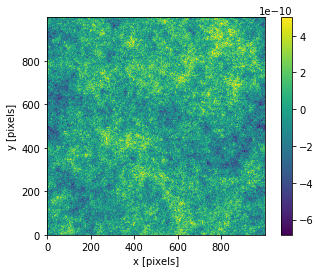

In [28]:
testtest2 = airyturbtest2 - airystarstest2
plt.imshow(testtest2, interpolation='none', origin='lower', vmax=0.0000000005)
plt.xlabel('x [pixels]')
plt.ylabel('y [pixels]')
plt.colorbar()
plt.show()

Text(0.5, 1.0, '250 stars')

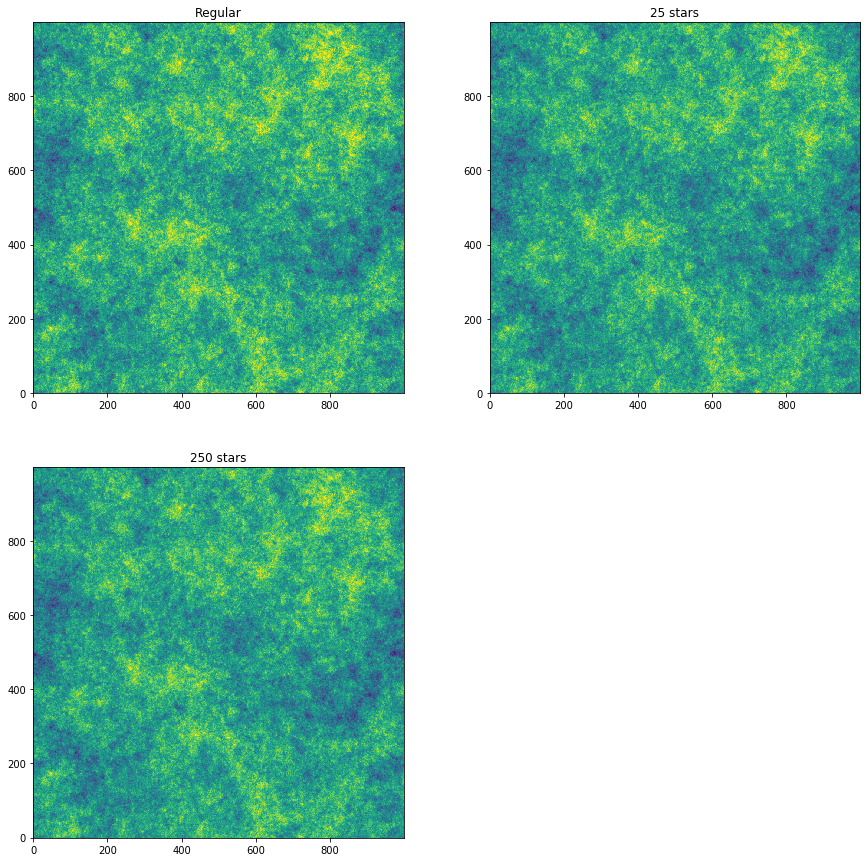

In [29]:
plt.figure(figsize=(15,15))
ax = plt.subplot(2,2,1)
ax.imshow(turbulence, origin='lower', vmax=0.5)
ax.set_title("Regular")
ax = plt.subplot(2,2,2)
ax.imshow(testtest, origin='lower', vmax=0.0000000005)
ax.set_title("25 stars")
ax = plt.subplot(2,2,3)
ax.imshow(testtest2, origin='lower', vmax=0.0000000005)
ax.set_title("250 stars")

#### Fourier Transform

In [30]:
ftest1 = np.fft.fft2(turbulenttest2) ##turbulence and stars and noise
ftest_turbulence_stars = (np.fft.ifft2(ftest1)).real
ftest2 = np.fft.fft2(starstest) #just stars and noise 
ftest_stars_only = (np.fft.ifft2(ftest2)).real
ftest = ftest_turbulence_stars - ftest_stars_only

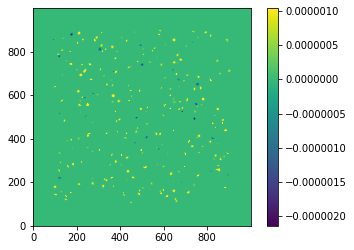

In [31]:
plt.imshow(ftest, interpolation='none', origin='lower', vmax = 0.00000104)
plt.colorbar()
plt.show()


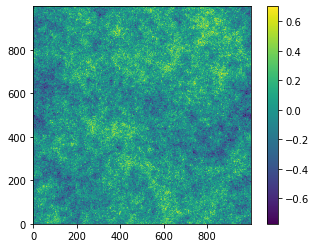

In [32]:
ftest3 = np.fft.fft2(turbulence) ##+ np.exp(-2j*np.pi*np.random.rand(1000,1000))
ftestno = (np.fft.ifft2(ftest3)).real
plt.imshow(ftestno, interpolation='none', origin='lower')
plt.colorbar()
plt.show()

Text(0.5, 1.0, '250 stars')

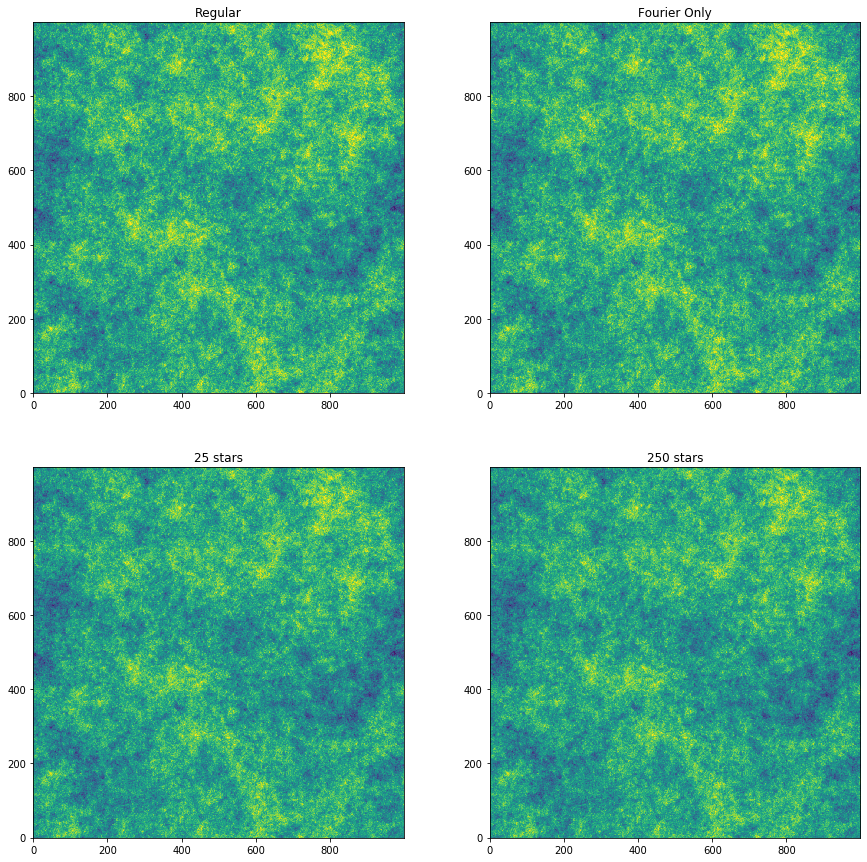

In [33]:
plt.figure(figsize=(15,15))
ax = plt.subplot(2,2,1)
ax.imshow(turbulence, origin='lower', vmax=0.5)
ax.set_title("Regular")
ax = plt.subplot(2,2,2)
ax.imshow(ftestno, origin='lower', vmax=0.5)
ax.set_title("Fourier Only")
ax = plt.subplot(2,2,3)
ax.imshow(testtest, origin='lower', vmax=0.0000000005)
ax.set_title("25 stars")
ax = plt.subplot(2,2,4)
ax.imshow(testtest2, origin='lower', vmax=0.0000000005)
ax.set_title("250 stars")

In [34]:
%run functions.py

<Figure size 432x288 with 0 Axes>